In [2]:
import numpy as np 
import pandas as pd
import os

In [413]:
directory = 'data/Sales Data/'
def read_multiple_tables(directory):
    df = pd.DataFrame()
    for folder in os.listdir(directory):
        if folder not in ['.DS_Store', '.ipynb_checkpoints']:
            for file in os.listdir(os.path.join(directory , folder)):
                if file != '.ipynb_checkpoints':
                    files_dir = os.path.join(directory , folder , file)
                    df_1 = pd.read_excel(files_dir, engine='pyxlsb')
                df = pd.concat([df , df_1] , axis = 0)
    return df

In [414]:
df = read_multiple_tables(directory)

In [415]:
df.head()

,Month,Billing Date,Sales Region,Sales Zone,Sales Type,Manufacturing Plant,Manufacturing Plant Name,Plant,Plant Name,Sold To Party Code,...,T Zone Desc,Brand,Product,Bill Quantity,Gross Bill Price,Zbill_Invoice_bill,Tzone Desc.,diff,Sold To Party District Name.1,Net Bill Price
0,44378,44378,South,Goa,Trade,1300,DCBL FACTORY-BELGAUM,1300,DCBL FACTORY-BELGAUM,7031240,...,Tzone Desc.,DALMIA,OPC,13.0,118300.0,118300.0,NaN,NaN,NaN,NaN
1,44378,44380,South,Goa,Trade,1300,DCBL FACTORY-BELGAUM,1300,DCBL FACTORY-BELGAUM,7015228,...,ALDONA,DALMIA,PPC,13.0,113100.0,113100.0,NaN,NaN,NaN,NaN
2,44378,44380,South,Goa,Trade,1300,DCBL FACTORY-BELGAUM,1300,DCBL FACTORY-BELGAUM,7015228,...,ST. LOURENCE,DALMIA,PPC,26.0,226200.0,226200.0,NaN,NaN,NaN,NaN
3,44378,44383,South,Goa,Trade,1300,DCBL FACTORY-BELGAUM,1300,DCBL FACTORY-BELGAUM,7031479,...,VASCO,DALMIA,PPC,13.0,113100.0,113100.0,NaN,NaN,NaN,NaN
4,44378,44383,South,Goa,Trade,1300,DCBL FACTORY-BELGAUM,1300,DCBL FACTORY-BELGAUM,7031240,...,VASCO,DALMIA,PPC,13.0,113100.0,113100.0,NaN,NaN,NaN,NaN


In [416]:
import datetime
def timeseries_conversion(excel_serial_number):
    reference_date = datetime.datetime(1900, 1, 1)
    dt = reference_date + datetime.timedelta(days=excel_serial_number - 2)
    return dt

In [417]:
df['Billing Date'] = df['Billing Date'].apply(timeseries_conversion)

In [418]:
from utility.datetime_util import create_date_columns
df_sales = create_date_columns([df])

In [419]:
important_cols = ['Sales Region', 'Sales Zone', 'Sales Type',
        'Sold To Party Code', 'Sold To Party District Name', 'Ship to Party Code',
        'Ship to Party District', 'Brand', 'Product', 'Bill Quantity', 'date', 'Month_Year',
       'Year', 'Quarter']

In [424]:
df_sales_new = df_sales[important_cols]
df_sales_new = df_sales_new[df_sales_new['Month_Year']>='2021-04']

In [425]:
doantion = df_sales_new[df_sales_new['Sold To Party Code']=='DONATION']
df_sales_new =df_sales_new[df_sales_new['Sold To Party Code']!='DONATION']

In [426]:
df_sales_new['Sold To Party Code'] = df_sales_new['Sold To Party Code'].astype(int)

In [427]:
#selecting only dealers from the dataframe
df_sales_new = df_sales_new[(df_sales_new['Sold To Party Code']>=7000000)&(df_sales_new['Sold To Party Code']<7100000)]

In [428]:
df_group_month = df_sales_new[['Sold To Party Code','Month_Year',
                     'Bill Quantity']].groupby(['Sold To Party Code',
                                                'Month_Year']).agg({'Bill Quantity': ['sum']}).reset_index()

In [429]:
df_group_month.columns = ['Sold To Party Code', 'Month Year' , 'Sum']

In [430]:
pivot_table = pd.pivot_table(df_group_month, values='Sum',
                       columns='Month Year', index = 'Sold To Party Code')

In [431]:
pivot_table['No_transaction'] = pivot_table.isna().sum(axis=1)

In [432]:
pivot_table = pivot_table.fillna(0)

In [433]:
def count_zeros_before_first_nonzero(row):
    count = 0
    for value in row:
        if value == 0:
            count += 1
        else:
            break 
    return count

In [434]:
pivot_table['Month_new_user'] = pivot_table.apply(count_zeros_before_first_nonzero , axis = 1)

In [435]:
def count_trailing_zeros_before_end_index(df, end_index):
    counts = []
    for row in df.itertuples(index=False):
        count = 0
        for i in range(end_index - 1, -1, -1):
            if row[i] == 0:
                count += 1
            else:
                break
        counts.append(count)
    return counts

In [436]:
result_matrix = pd.DataFrame(index = pivot_table.index)
for i in range(len(pivot_table.columns)+1):
    string = str(i)
    result_matrix[string] = count_trailing_zeros_before_end_index(pivot_table, i)

In [437]:
result_matrix

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
7000010,0,0,0,1,0,0,1,0,0,0,...,0,0,1,2,3,4,5,6,0,1
7000015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,3,0,1
7000019,0,0,0,0,0,0,0,1,0,1,...,8,9,10,11,12,13,14,15,0,1
7000022,0,1,2,3,4,5,6,7,8,9,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039320,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,0,0,0
7039324,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,0,0,0
7039325,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,0,0,0


In [438]:
result_matrix.drop(['0','24' , '25'] , axis = 1 , inplace = True)

In [439]:
result_matrix.columns = ['S_2021-04', 'S_2021-05', 'S_2021-06', 'S_2021-07', 'S_2021-08', 'S_2021-09',
       'S_2021-10', 'S_2021-11', 'S_2021-12', 'S_2022-01', 'S_2022-02', 'S_2022-03',
       'S_2022-04', 'S_2022-05', 'S_2022-06', 'S_2022-07', 'S_2022-08', 'S_2022-09',
       'S_2022-10', 'S_2022-11', 'S_2022-12', 'S_2023-01', 'S_2023-02']

In [440]:
def inactive(value):
    if value == 0: 
        return 'Active'
    elif value == 1: 
        return 'Active_1N'
    elif value == 2: 
        return 'Active_2N'
    elif value == 3: 
        return 'Active_3N'
    elif value>3 and value <=12:
        return 'Inactive'
    else: 
        return 'Churn'

In [441]:
for i in result_matrix.columns:
    result_matrix[i] = result_matrix[i].apply(inactive)

In [442]:
result_matrix['Month_new_user'] = pivot_table['Month_new_user']

In [445]:
pivot_table
# result_matrix_copy_1 = result_matrix.copy()
# for i in range(result_matrix.shape[0]):
#     value = result_matrix_copy_1.iloc[i,22]
#     #print(result_matrix_copy_1.iloc[:, :value])
    
#     result_matrix_copy_1.iloc[i, :value] = '-'

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,No_transaction,Month_new_user
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,22.0,40.0,20.0,20.0,20.0,122.5,75.0,90.00,0,0
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,33.8,24.0,0.0,0.0,0.0,0.0,0.0,0.00,10,0
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,42.0,109.0,45.0,74.0,27.0,0.0,0.0,0.00,3,0
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,16,0
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,24.0,24.0,22.0,5.0,21.0,24.0,0.00,14,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.00,22,22
7039324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.00,22,22
7039325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.00,22,22


In [446]:
result_matrix_copy_1

,S_2021-04,S_2021-05,S_2021-06,S_2021-07,S_2021-08,S_2021-09,S_2021-10,S_2021-11,S_2021-12,S_2022-01,...,S_2022-06,S_2022-07,S_2022-08,S_2022-09,S_2022-10,S_2022-11,S_2022-12,S_2023-01,S_2023-02,Month_new_user
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,0
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,Active_1N,Active,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,0
7000015,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active_1N,Active_2N,Active_3N,0
7000019,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active_2N,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,Churn,Churn,0
7000022,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Active,Active,Active,Active,Active,Active,Active,Active,Active_1N,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039320,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Active,22
7039324,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Active,22
7039325,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Active,22


In [138]:
#result_matrix_copy_1.drop('Month_new_user' , axis = 1 , inplace = True)
churn_analysis = pd.DataFrame(columns = ['Inactive' , 'Churn' , 'Active'] , index = result_matrix_copy_1.columns)
for i in range(12 , 70):
    cols = [result_matrix_copy_1.columns[i], result_matrix_copy_1.columns[i+1]]
    #print(cols)

    churn_analysis.loc[cols[0] , 'Inactive'] = result_matrix_copy_1[result_matrix_copy_1[cols[0]]=='Inactive'].shape[0]
    churn_analysis.loc[cols[0] , 'Churn'] = result_matrix_copy_1[(result_matrix_copy_1[cols[0]]=='Inactive')&(result_matrix_copy_1[cols[1]]=='Churn')].shape[0]
    churn_analysis.loc[cols[0] , 'Active'] = result_matrix_copy_1[(result_matrix_copy_1[cols[0]]=='Churn')&(result_matrix_copy_1[cols[1]]=='Active')].shape[0]

In [139]:
churn_analysis = churn_analysis.dropna()

In [140]:
churn_analysis['%_churn_month'] = (churn_analysis['Churn']/churn_analysis['Inactive'])*100
#churn_analysis['%_active_month'] = (churn_analysis['Active']/churn_analysis['Churn'])*100

In [141]:
churn_analysis.head()

,Inactive,Churn,Active,%_churn_month
S_2018-04,1613,155,0,9.609423
S_2018-05,1599,156,3,9.756098
S_2018-06,1561,237,6,15.182575
S_2018-07,1579,160,3,10.132996
S_2018-08,1623,136,2,8.379544


In [ ]:
churn_analysis.to_csv('data/churn_month.csv')

## Data Preparation for churn prediction 

In [447]:
#count the number of Active_1N, Active_2N, Active_3N
def count_active_1n(row):
    return row.str.count('Active_1N').sum()
result_matrix_copy_1['Active_1N_Count'] = result_matrix_copy_1.apply(lambda row: count_active_1n(row), axis=1).astype(int)
def count_active_2n(row):
    return row.str.count('Active_2N').sum()
result_matrix_copy_1['Active_2N_Count'] = result_matrix_copy_1.apply(lambda row: count_active_2n(row), axis=1).astype(int)
def count_active_3n(row):
    return row.str.count('Active_3N').sum()
result_matrix_copy_1['Active_3N_Count'] = result_matrix_copy_1.apply(lambda row: count_active_3n(row), axis=1).astype(int)

def count_inactive(row):
    return row.str.count('Inactive').sum()
result_matrix_copy_1['Inactive_Count'] = result_matrix_copy_1.apply(lambda row: count_inactive(row), axis=1).astype(int)

result_matrix_copy_1


,S_2021-04,S_2021-05,S_2021-06,S_2021-07,S_2021-08,S_2021-09,S_2021-10,S_2021-11,S_2021-12,S_2022-01,...,S_2022-10,S_2022-11,S_2022-12,S_2023-01,S_2023-02,Month_new_user,Active_1N_Count,Active_2N_Count,Active_3N_Count,Inactive_Count
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,0,0,0,0,0
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,Active_2N,Active_3N,Inactive,Inactive,Inactive,0,5,1,1,3
7000015,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active_1N,Active_2N,Active_3N,0,1,1,1,0
7000019,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active_2N,...,Inactive,Inactive,Churn,Churn,Churn,0,2,1,1,9
7000022,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Active,Active,Active,Active,Active_1N,13,2,1,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039320,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Active,22,1,1,1,9
7039324,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Active,22,1,1,1,9
7039325,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Active,22,1,1,1,9


In [448]:
#Share_of_wallet
sow = pd.read_excel('data/DAP_Data_SOW.xlsx')
sow.head()

,sap_mmp_mapping_status,counter_name,dap_id,sap_id,Type_SAP,counter_type,territory_id,block_taluka_mm,district_id_mm,sap_active,mmp_active,is_business_closed,is_cement_counter,mm_created_on,WS Potential,RET Potential,DCBL Pot Vol,Total Potential,Region
0,Verified Location Received,JAYA DURGA STORE,2.0,7022511.0,DLR,MKT DLR,EA0101040000005,1.010010e+12,101001001.0,N,Y,yes,yes,2020-03-31,0.0,1.0,0.0,1.0,EAST
1,Verified Location Received,PRABINA KUMAR SAHOO,3.0,77044910.0,SDLR,SDLR,EA0101040000005,1.010010e+12,101001001.0,Y,Y,yes,yes,2020-03-31,0.0,175.0,175.0,175.0,EAST
2,Verified Location Received,BRAJABIHARI SAHU,4.0,77043185.0,SDLR,SDLR,EA0101040000005,1.010010e+12,101001001.0,Y,Y,no,yes,2020-03-31,0.0,250.0,230.0,250.0,EAST
3,Verified Location Received,PRATAP KUMAR SAHOO,5.0,77010854.0,SDLR,SDLR,EA0101040000004,1.010010e+12,101001001.0,Y,Y,no,yes,2020-03-31,0.0,100.0,60.0,100.0,EAST
4,Verified Location Received,DIPTI RANJAN RATH,6.0,77008300.0,SDLR,SDLR,EA0101040000004,1.010010e+12,101001001.0,Y,Y,no,yes,2020-03-31,0.0,300.0,100.0,300.0,EAST


In [449]:
sow = sow[(sow['sap_id']>=7000000)&(sow['sap_id']<7100000)][['sap_id' , 'DCBL Pot Vol' , 'Total Potential', 'is_business_closed', 'sap_active']]

In [450]:
sow['sap_id'] = sow['sap_id'].astype(int)

In [451]:
sow = sow[sow['is_business_closed']=='no']
#sow = sow[sow['sap_active']=='Y']

In [452]:
sow.columns

Index(['sap_id', 'DCBL Pot Vol', 'Total Potential', 'is_business_closed',
       'sap_active'],
      dtype='object')

In [453]:
sow.index = sow['sap_id']
sow.drop('sap_id' , axis = 1 , inplace = True)

In [454]:
sow = sow.dropna(axis=0)

In [455]:
sow

,DCBL Pot Vol,Total Potential,is_business_closed,sap_active
sap_id,,,,
7007175,30.0,130.0,no,N
7008784,0.0,350.0,no,N
7024426,0.0,105.0,no,N
7008885,0.0,115.0,no,N
7000811,0.0,190.0,no,N
...,...,...,...,...
7040834,50.0,50.0,no,Y
7040835,0.0,1000.0,no,Y
7040821,645.0,645.0,no,Y


In [456]:
sow['share_of_wallet']= (sow['DCBL Pot Vol']/sow['Total Potential'])*100
sow = sow[['share_of_wallet']]

In [457]:
result = result_matrix_copy_1.merge(sow, left_index=True, right_index=True, how='left')

In [458]:
#result = result.dropna(axis = 0 )
result

,S_2021-04,S_2021-05,S_2021-06,S_2021-07,S_2021-08,S_2021-09,S_2021-10,S_2021-11,S_2021-12,S_2022-01,...,S_2022-11,S_2022-12,S_2023-01,S_2023-02,Month_new_user,Active_1N_Count,Active_2N_Count,Active_3N_Count,Inactive_Count,share_of_wallet
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,0,0,0,0,0,48.800000
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,Active_3N,Inactive,Inactive,Inactive,0,5,1,1,3,20.000000
7000015,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active_1N,Active_2N,Active_3N,0,1,1,1,0,14.893617
7000019,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active_2N,...,Inactive,Churn,Churn,Churn,0,2,1,1,9,NaN
7000022,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Active,Active,Active,Active_1N,13,2,1,1,9,7.894737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039320,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Active,22,1,1,1,9,25.000000
7039324,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Active,22,1,1,1,9,100.000000
7039325,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Active,22,1,1,1,9,16.000000


In [284]:
#Non Billing Reason
non_billing = pd.read_excel('data/non_billing_reason_data.xlsb' , engine='pyxlsb')

In [285]:
non_billing['party_code'] = pd.to_numeric(non_billing['party_code'], errors='coerce')
non_billing = non_billing[(non_billing['party_code']>=7000000)&(non_billing['party_code']<7100000)]

In [286]:
from utility.datetime_util import timeseries_conversion
non_billing['last_reason_date'] = non_billing['last_reason_date'].apply(timeseries_conversion)

In [287]:
non_billing['party_code'] = non_billing['party_code'].astype(int)

In [288]:
non_billing = non_billing.rename(columns={'last_reason_date': 'Billing Date'})

In [289]:
non_billing.columns

Index(['salesofficer_id', 'party_code', 'dap_id', 'Billing Date',
       'reason_desc'],
      dtype='object')

In [290]:
from utility.datetime_util import create_date_columns
non_billing = create_date_columns([non_billing])

In [291]:
non_billing = non_billing[['party_code' , 'reason_desc' , 'Month_Year']]
non_billing = non_billing.sort_values('party_code')

In [296]:
non_billing['Month_Year'] = pd.to_datetime(non_billing['Month_Year']) 

In [297]:
grouped = non_billing.groupby(['party_code', pd.Grouper(key='Month_Year', freq='M')])['reason_desc'].agg(list).reset_index()

In [298]:
grouped

,party_code,Month_Year,reason_desc
0,7000004,2022-08-31,[Inventory - Dealer has stock]
1,7000004,2022-10-31,[Personal Reason to Dealer]
2,7000006,2021-08-31,[Current pricing issue - Net Billing of many B...
3,7000006,2021-09-30,[Current pricing issue - Net Billing of many B...
4,7000006,2021-10-31,[Current pricing issue - Net Billing of many B...
...,...,...,...
70527,7048123,2023-01-31,"[Personal Reason to Dealer, Personal Reason to..."
70528,7048123,2023-02-28,"[Personal Reason to Dealer, Personal Reason to..."
70529,7048123,2023-03-31,"[Personal Reason to Dealer, Personal Reason to..."
70530,7086359,2022-03-31,[Inventory - Dealer has stock]


In [302]:
grouped = grouped.rename(columns={'Month_Year': 'Billing Date'})

In [304]:
grouped = create_date_columns([grouped]).drop(['Year', 'Quarter'], axis= 1)

In [308]:
grouped = grouped.drop('Billing Date' , axis =1 )

In [310]:
grouped.index = grouped['party_code']

In [311]:
grouped.drop('party_code', axis = 1 , inplace = True)

In [313]:
#for the current month
grouped_curr = grouped[grouped['Month_Year']=='2023-01']

In [314]:
grouped_curr

,reason_desc,Month_Year
party_code,,
7000010,"[Un-resolved issues with company, Personal Rea...",2023-01
7000061,[Converted to sub dealer Ã¢â‚¬â€œ buy from who...,2023-01
7000064,[Inventory - Dealer has stock],2023-01
7000085,[Creditor - Credit limit exhausted with Dalmia...,2023-01
7000091,[Creditor - Credit limit exhausted with Dalmia],2023-01
...,...,...
7039006,[Awaiting pending discount settlement],2023-01
7039008,[Personal Reason to Dealer],2023-01
7039030,[Debtors - Dealer awaiting payments from his c...,2023-01


In [487]:
df_1N = result[result['S_2023-01']=='Active_1N']

In [488]:
df_1N_inner =df_1N.merge(grouped_curr, left_index=True, right_index=True, how='inner')

In [1]:
df_1N_inner

NameError: name 'df_1N_inner' is not defined

### The data for the Dealers who were in Active_1N for the month of January the complaint data is really less, so cannot be used as a variable.

In [537]:
#joining pivot table and the result matrix
#result.drop('Month_new_user', axis = 1 , inplace = True)
df =result.merge(pivot_table, left_index=True, right_index=True, how='inner')

In [538]:
df.drop('Month_new_user_y', axis =1 , inplace=True)

In [539]:
df

,S_2021-04,S_2021-05,S_2021-06,S_2021-07,S_2021-08,S_2021-09,S_2021-10,S_2021-11,S_2021-12,S_2022-01,...,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,No_transaction
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,35.0,22.0,40.0,20.0,20.0,20.0,122.5,75.0,90.00,0
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,0.0,33.8,24.0,0.0,0.0,0.0,0.0,0.0,0.00,10
7000015,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,85.0,42.0,109.0,45.0,74.0,27.0,0.0,0.0,0.00,3
7000019,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active_2N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,16
7000022,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,1.5,12.0,24.0,24.0,22.0,5.0,21.0,24.0,0.00,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039320,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.00,22
7039324,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.00,22
7039325,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.00,22


In [540]:
df = df[df['Month_new_user_x']<=10]

In [541]:
df

,S_2021-04,S_2021-05,S_2021-06,S_2021-07,S_2021-08,S_2021-09,S_2021-10,S_2021-11,S_2021-12,S_2022-01,...,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,No_transaction
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,35.0,22.0,40.0,20.0,20.0,20.00,122.5,75.0,90.00,0
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,0.0,33.8,24.0,0.0,0.0,0.00,0.0,0.0,0.00,10
7000015,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,85.0,42.0,109.0,45.0,74.0,27.00,0.0,0.0,0.00,3
7000019,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active_2N,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,16
7000025,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,136.0,175.0,150.0,95.0,48.0,108.80,73.0,167.0,137.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035898,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,75.0,50.0,150.0,25.0,25.0,25.00,25.0,25.0,50.00,10
7035902,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,20
7035904,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,150.0,117.0,200.0,205.0,154.0,156.00,302.5,292.0,309.20,10


In [542]:
yoy = pd.read_csv('~/Downloads/Dalmia_machine_learning/Nikhil/Experiment_folder/yoy_qoq.csv')

In [543]:
yoy.index = yoy['Sold To Party Code']

In [544]:
yoy.drop('Sold To Party Code' , axis =1 , inplace = True)

In [545]:
yoy = yoy[['Mean_QOQ_Oct','Mean_QOQ_Nov' , 'Mean_QOQ_Dec', 'Mean_QOQ_Jan' ,'Mean_YoY_Oct' ,'Mean_YoY_Nov', 'Mean_YoY_Dec', 'Mean_YoY_Jan']]

In [546]:
yoy

,Mean_QOQ_Oct,Mean_QOQ_Nov,Mean_QOQ_Dec,Mean_QOQ_Jan,Mean_YoY_Oct,Mean_YoY_Nov,Mean_YoY_Dec,Mean_YoY_Jan
Sold To Party Code,,,,,,,,
7000004,-26.829268,-26.829268,98.170732,38.461538,-33.600000,-33.600000,7.400000,27.600000
7000010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7000015,13.265306,-22.704082,-22.704082,0.000000,11.060948,-20.767494,-20.767494,0.000000
7000025,-65.714286,-44.000000,-45.285714,118.015666,-44.515103,-15.516693,-17.233704,70.588235
7000027,-58.969974,-54.728574,-62.501491,-56.411072,-109.702837,-106.834745,-112.090897,-131.101251
...,...,...,...,...,...,...,...,...
7035898,-66.666667,-66.666667,-66.666667,0.000000,0.000000,0.000000,0.000000,0.000000
7035902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7035904,-11.494253,-10.919540,17.337165,43.020408,0.000000,0.000000,0.000000,0.000000


In [547]:
df =df.merge(yoy, left_index=True, right_index=True, how='inner')

In [548]:
df = df.dropna(axis = 0)

In [549]:
df

,S_2021-04,S_2021-05,S_2021-06,S_2021-07,S_2021-08,S_2021-09,S_2021-10,S_2021-11,S_2021-12,S_2022-01,...,2023-02,No_transaction,Mean_QOQ_Oct,Mean_QOQ_Nov,Mean_QOQ_Dec,Mean_QOQ_Jan,Mean_YoY_Oct,Mean_YoY_Nov,Mean_YoY_Dec,Mean_YoY_Jan
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,90.00,0,-26.829268,-26.829268,98.170732,38.461538,-33.600000,-33.600000,7.400000,27.600000
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,0.00,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7000015,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,0.00,3,13.265306,-22.704082,-22.704082,0.000000,11.060948,-20.767494,-20.767494,0.000000
7000025,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,137.00,0,-65.714286,-44.000000,-45.285714,118.015666,-44.515103,-15.516693,-17.233704,70.588235
7000027,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,35.00,0,-58.969974,-54.728574,-62.501491,-56.411072,-109.702837,-106.834745,-112.090897,-131.101251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035898,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,50.00,10,-66.666667,-66.666667,-66.666667,0.000000,0.000000,0.000000,0.000000,0.000000
7035902,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,0.00,20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7035904,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,309.20,10,-11.494253,-10.919540,17.337165,43.020408,0.000000,0.000000,0.000000,0.000000


In [550]:
df[df['S_2023-01']=='Active_1N']

,S_2021-04,S_2021-05,S_2021-06,S_2021-07,S_2021-08,S_2021-09,S_2021-10,S_2021-11,S_2021-12,S_2022-01,...,2023-02,No_transaction,Mean_QOQ_Oct,Mean_QOQ_Nov,Mean_QOQ_Dec,Mean_QOQ_Jan,Mean_YoY_Oct,Mean_YoY_Nov,Mean_YoY_Dec,Mean_YoY_Jan
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000139,Active,Active,Active_1N,Active,Active,Active,Active,Active,Active,Active,...,48.0,2,0.000000,8.333333,13.888889,0.0,-24.519231,-12.980769,-5.288462,0.0
7000262,Active,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active_1N,Active,...,0.0,8,0.000000,0.000000,0.000000,0.0,-55.384615,-55.384615,-55.384615,0.0
7000310,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,5.0,1,-28.125000,-56.250000,-50.000000,0.0,-53.716216,-71.959459,-67.905405,0.0
7000468,Active,Active,Active,Active,Active,Active,Active,Active_1N,Active_2N,Active,...,0.0,12,0.000000,0.000000,0.000000,0.0,0.000000,-156.410256,-143.589744,0.0
7000609,Active,Active,Active,Active_1N,Active,Active,Active,Active,Active,Active,...,40.0,2,-25.000000,-25.000000,-20.000000,0.0,-12.012012,-12.012012,-9.009009,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035664,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,0.0,14,-52.941176,-47.117647,-49.058824,0.0,0.000000,0.000000,0.000000,0.0
7035724,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,53.0,13,0.000000,321.212121,352.878788,0.0,0.000000,0.000000,0.000000,0.0
7035763,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,0.0,14,-51.411043,-51.411043,-39.141104,0.0,0.000000,0.000000,0.000000,0.0


In [551]:
X = df[df['S_2023-01']=='Active_1N'][['2022-11', '2022-12',
       '2023-01','Mean_QOQ_Nov', 'Mean_QOQ_Dec',
       'Mean_QOQ_Jan', 'Mean_YoY_Nov', 'Mean_YoY_Dec', 'Mean_YoY_Jan', 'share_of_wallet','Active_1N_Count', 'Active_2N_Count', 'Active_3N_Count',
       'Inactive_Count']]

In [552]:
y = df[df['S_2023-01']=='Active_1N']['S_2023-02']

            Feature  Importance
11  Active_2N_Count    0.407794
12  Active_3N_Count    0.150326
10  Active_1N_Count    0.103558
6      Mean_YoY_Nov    0.067900
1           2022-12    0.065663
9   share_of_wallet    0.048780
4      Mean_QOQ_Dec    0.047402
7      Mean_YoY_Dec    0.047347
0           2022-11    0.026392
13   Inactive_Count    0.019504
3      Mean_QOQ_Nov    0.015333
2           2023-01    0.000000
5      Mean_QOQ_Jan    0.000000
8      Mean_YoY_Jan    0.000000


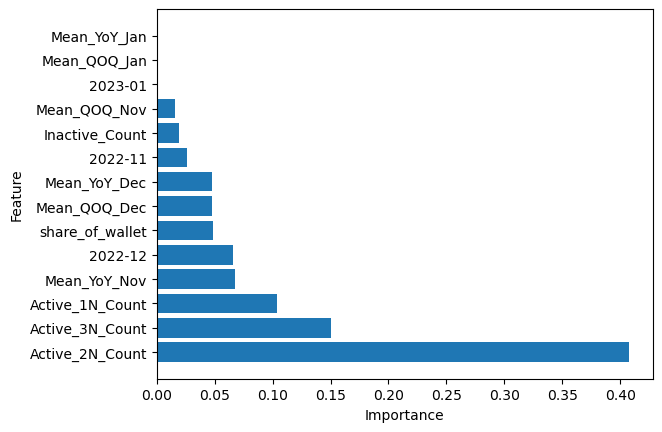

In [553]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
clf = DecisionTreeClassifier()

# Fit the classifier to the data
clf.fit(X, y)

# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by importance (descending order)
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Print the feature importances
print(feature_importances)

# Plot the feature importances
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [554]:
#for active dealers


In [555]:
X = df[df['S_2022-12']=='Active'][['2022-10','2022-11', '2022-12','Mean_QOQ_Oct','Mean_QOQ_Nov', 'Mean_QOQ_Dec',
                                   'Mean_YoY_Oct','Mean_YoY_Nov', 'Mean_YoY_Dec', 'share_of_wallet','Active_1N_Count', 'Active_2N_Count', 'Active_3N_Count',
       'Inactive_Count']]
y = df[df['S_2022-12']=='Active'][['S_2022-12','S_2023-01','S_2023-02']]

In [556]:
y['1-2'] = ((y['S_2022-12'] == 'Active') & (y['S_2023-01'] == 'Active_1N')).astype(int)
y['2-3'] = (((y['S_2023-01'] == 'Active_1N') & (y['S_2023-02'] == 'Active_2N'))|((y['S_2023-01'] == 'Active') & (y['S_2023-02'] == 'Active_1N'))).astype(int)

In [557]:
y = y[['1-2','2-3']]

            Feature  Importance
10  Active_1N_Count    0.214866
5      Mean_QOQ_Dec    0.088993
8      Mean_YoY_Dec    0.086060
4      Mean_QOQ_Nov    0.080839
3      Mean_QOQ_Oct    0.074600
1           2022-11    0.073025
2           2022-12    0.071569
9   share_of_wallet    0.068971
0           2022-10    0.061402
11  Active_2N_Count    0.050006
7      Mean_YoY_Nov    0.041306
6      Mean_YoY_Oct    0.039125
12  Active_3N_Count    0.025434
13   Inactive_Count    0.023805


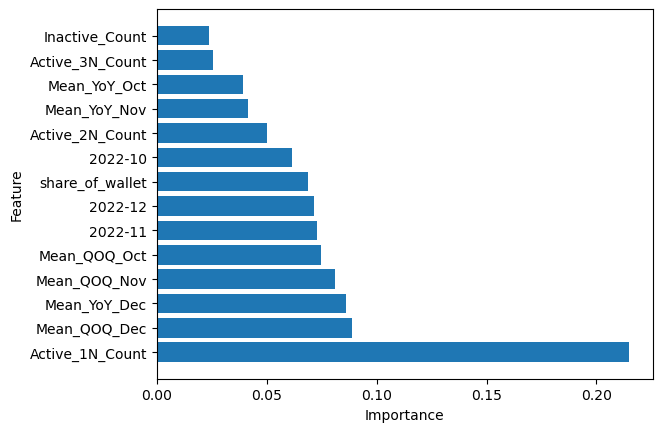

In [558]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
clf = DecisionTreeClassifier()

# Fit the classifier to the data
clf.fit(X, y)

# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by importance (descending order)
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Print the feature importances
print(feature_importances)

# Plot the feature importances
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [559]:
y = y['1-2']

            Feature  Importance
10  Active_1N_Count    0.216019
4      Mean_QOQ_Nov    0.094061
9   share_of_wallet    0.082736
5      Mean_QOQ_Dec    0.076283
2           2022-12    0.069642
3      Mean_QOQ_Oct    0.068739
7      Mean_YoY_Nov    0.064235
8      Mean_YoY_Dec    0.063224
6      Mean_YoY_Oct    0.061910
11  Active_2N_Count    0.051021
1           2022-11    0.049817
0           2022-10    0.044637
13   Inactive_Count    0.035930
12  Active_3N_Count    0.021747


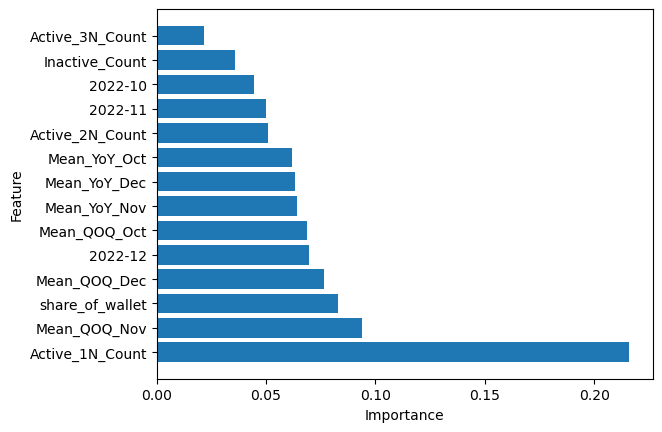

In [560]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
clf = DecisionTreeClassifier()

# Fit the classifier to the data
clf.fit(X, y)

# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by importance (descending order)
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Print the feature importances
print(feature_importances)

# Plot the feature importances
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()